In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_abundance_order, get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

# from mcspace.fig_utils import *
import matplotlib.colors as mcolors

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
pwd

'C:\\Users\\Gary2\\Partners HealthCare Dropbox\\Gurdip Uppal\\research_bwh\\MCSPACE_FINAL\\MCSPACE\\mcspace\\paper\\figures'

In [4]:
rootpath = Path("../../")
basepath = Path("./")

In [5]:
runpath = rootpath / "paper" / "human_runs" / "runs"

In [6]:
treepath = rootpath / "data" / "human_experiments" / "human_otus_tree" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [7]:
outpath = basepath / "figs_human_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model results

In [8]:
respath = get_min_loss_path(runpath, np.arange(10))

0
1
2
3
4
5
6
7
8
9
3


In [9]:
model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][1].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

In [10]:
print(times)
print(subjects)
print(num_otus)

[1, 2, 3, 4, 5]
['H11']
58


In [11]:
taxonomy.head()

,Kingdom,Phylum,Class,Order,Family,Genus
Otu,,,,,,
Otu121,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,na
Otu14,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,na
Otu150,Bacteria,Firmicutes,Clostridia,Oscillospirales,Oscillospiraceae,uncultured
Otu37,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Otu6,Bacteria,Actinobacteriota,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium


### load gappa taxonomy (save elsewhere...)

In [12]:
satfile =  rootpath / "data" / "human_experiments" / "gappa_taxonomy" / "sativa_taxonomy.csv"
sattax = pd.read_csv(satfile, index_col=0)

In [13]:
sattax.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
OTU1720,Bacteria,Firmicutes,Clostridia,Clostridiales,Oscillospiraceae,Oscillibacter,Oscillibacter valericigenes
OTU3529,Bacteria,Proteobacteria,Gammaproteobacteria,Thiotrichales,Thiotrichaceae,Thiothrix,na
OTU3620,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,na
OTU93,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,na
OTU3524,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans


In [14]:
taxlist = list(taxonomy.index)
sattaxsub = [x.upper() for x in taxlist]

In [15]:
sattax = sattax.loc[sattaxsub,:]

In [16]:
# sattax

In [17]:
mapper = {idx: idx.capitalize() for idx in sattax.index}
sattax2 = sattax.rename(index=mapper)
sattax2.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,na,na,na
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na


#### relabel blasted taxa (do elsewhere...)

In [18]:
name_updates = {'Otu1': {'Species': 'Agathobacter rectalis'},
'Otu14': {'Species': 'Roseburia inulinivorans'},
'Otu17': {'Genus': 'Ruminococcus'},
'Otu66': {'Genus': 'Thomasclavelia'},
'Otu10': {'Species': 'Ruminococcus bromii'},
'Otu59': {'Family': 'Oscillospiraceae'},
'Otu7': {'Family': 'Bacillaceae'},
'Otu150': {'Genus': 'Porphyromonas'},
'Otu3': {'Species': 'Bacteroides dorei'}}

In [19]:
for oidx in name_updates.keys():
    replace = name_updates[oidx]
    key = list(replace.keys())[0]
    newname = replace[key]
    sattax2.loc[oidx,key] = newname

In [20]:
# sattax2

In [21]:
taxonomy = sattax2

In [22]:
taxonomy.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,na,Porphyromonas,na
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na


## TO DO: clean up taxonomy loading...

# Get summary results

In [23]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

In [25]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005108,-2.291752
1,1,H11,A2,0.006969,-2.156850
2,1,H11,A3,0.027590,-1.559243
3,1,H11,A4,0.012346,-1.908481
4,1,H11,A5,0.060185,-1.220512
...,...,...,...,...,...
340,5,H11,A65,0.006997,-2.155062
341,5,H11,A66,0.005332,-2.273112
342,5,H11,A67,0.009357,-2.028851
343,5,H11,A68,0.001217,-2.914721


# Render figure

### methods (move to utils)

In [26]:
def get_abundance_order(betadf):
    betadf_drop = betadf[['Assemblage', 'Value']]
    aveval = betadf_drop.groupby('Assemblage').mean()
    beta_order = aveval.sort_values(by='Value', ascending=False).index
    return beta_order

In [27]:
# vs plot_proportions_timepoint_subjects...?
def plot_subject_proportions_timeseries(ax, betadf, subj, order, logscale=True, vmin=-2, vmax=0, cmap='Blues',
                                   linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=True,
                                   square=False, cbar=False):
    if logscale is True:
        val = 'log10Value'
    else:
        val = 'Value'
        
    betasub = betadf.loc[(betadf['Subject'] == subj),:]
    betamatrix = betasub.pivot(index='Time', columns='Assemblage', values=val)
    ax=sns.heatmap(betamatrix.loc[:,order], ax=ax, cmap=cmap, square=square, vmin=vmin, vmax=vmax, cbar=cbar,
               linewidth=linewidth, linecolor=linecolor, xticklabels=xticklabels, yticklabels=yticklabels)
    return ax

In [28]:
def get_lowest_level(otu, taxonomy):
    taxonomies = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Domain']
    for level in taxonomies:
        levelid = taxonomy.loc[otu,level]
        if levelid != 'na':
            return levelid, level

In [31]:
def plot_phylo_tree(ax, tree, taxonomy, fontsize=16, text_len=41):            
    TEXT_LEN=text_len
    prefix_taxa = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****',
                   'Class': '*****', 'Phylum': '******', 'Domain': '*******'}

    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    taxa_order = []

    for text in ax.texts:
        taxonname = str(text._text).replace(' ','').capitalize()
        otu_name = taxonname
        taxa_order.append(otu_name)
        name, level = get_lowest_level(otu_name, taxonomy)
        prefix = prefix_taxa[level]
        taxonname = ' ' + prefix + ' ' + name + ' ' + otu_name
        text._text = taxonname
        text._text = text._text + '- ' * (TEXT_LEN - len(text._text))
        text.set_fontsize(fontsize)
    
    ax = remove_border(ax)
    return ax, taxa_order

In [32]:
def plot_assemblages(ax, thetadf, otu_order, beta_order, cmap=None, logscale=True, vmin=-2, vmax=0,
               linecolor ='#e6e6e6', linewidth=0.5, xticklabels=True, yticklabels=False,
               square=False, cbar=False):
    
    # reset multiindex
    thetatemp = thetadf.reset_index()
    thetatemp=thetatemp.set_index('Otu')
    
    if logscale is True:
        thetaplot = np.log10(thetatemp.loc[otu_order,:][beta_order] + 1e-20)
    else:
        thetaplot = thetatemp.loc[otu_order,:][beta_order]
    
    if cmap is None:
        green = sns.light_palette("green", reverse=False, as_cmap=True)
        green.set_under('white')
        cmap=green
    cbar_kws = dict(extend='min')

    ax=sns.heatmap(thetaplot, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, linecolor=linecolor, linewidth=linewidth,
               xticklabels=xticklabels, yticklabels=yticklabels, square=square, cbar=cbar, cbar_kws=cbar_kws)
    return ax

In [33]:
def remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

In [34]:
def add_border(ax, color='black'):
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color(color)
    return ax

In [44]:
# TODO : fix tree names so standardized?...
def get_pruned_tree(treepath, treefile, taxonomy, temppath=Path("./_tmp")):
    tree = ete3.Tree((treepath / treefile).as_posix())
    print("original tree size:", len(tree))
    taxaids = list(taxonomy.index)
    taxaids = [idx.upper() for idx in taxaids] # HOW TO KNOW IF NEEDED?...
    tree.prune(taxaids, True)
    print("pruned tree size:", len(tree))
    
    treeout = "tree.nhx"
    temppath.mkdir(exist_ok=True, parents=True)
    tree.write(outfile=(temppath / treeout).as_posix())
    phylo_tree = Phylo.read(temppath / treeout, format='newick')
    return phylo_tree

## settings

In [49]:
taxonomy.rename(columns={"Kingdom":"Domain"}, inplace=True)

In [50]:
fontsize = 12
subfontsize = 8

In [51]:
nsubj = len(subjects)
ntime = len(times)
notus, ncomm = thetadf.shape

## plot

In [52]:
ncomm_max = 120
notu_max = 120

tree_ratio = 0.1
gap_ratio = 0.15

original tree size: 3923
pruned tree size: 58


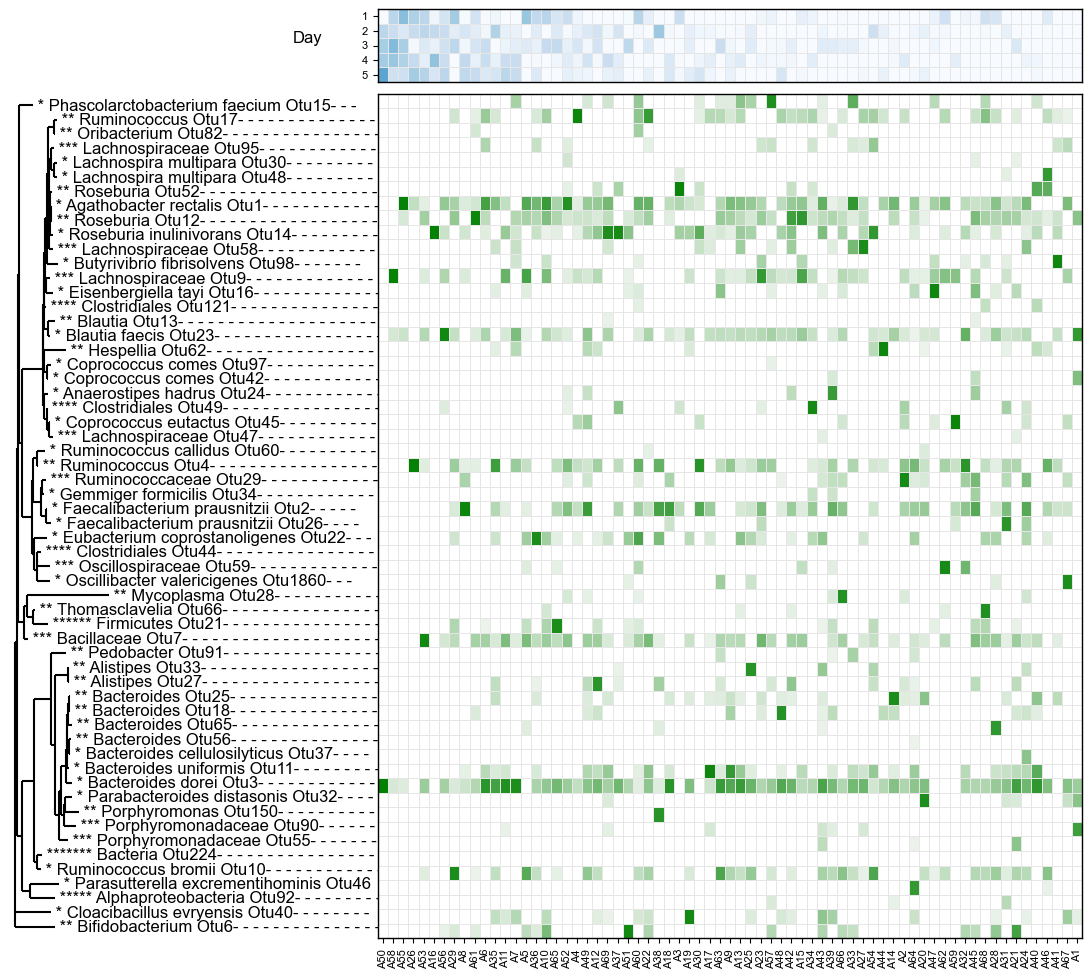

In [56]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max]
hratios.append(notus/notu_max)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=1+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_tree = fig.add_subplot(gs[1,0])
ax_theta = fig.add_subplot(gs[1,2])

# plot assemlage proportions
beta_order = get_abundance_order(betadf)

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=50, ha='left', fontsize=fontsize)
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=plot_assemblages(ax_theta, thetadf, otu_order, beta_order) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)